In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Chargement des données
data_train = pd.read_csv('KDDTrain+.txt', header=None)
data_train.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                      'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
                      'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
                      'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
                      'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                      'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                      'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                      'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome', 'level']

# Définition des colonnes catégorielles
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']

# Prétraitement des données
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1

    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

# Scaling des données
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df

# Prétraitement des données
scaled_train = preprocess(data_train)

# Séparation des données en features et labels
x = scaled_train.drop(['outcome', 'level'], axis=1).values
y = scaled_train['outcome'].values

# Réduction de dimension avec PCA
pca = PCA(n_components=20)
pca = pca.fit(x)
x_reduced = pca.transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

# Conversion des labels en entiers
y = y.astype('int')

# Séparation des données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

# Définition de l'architecture du modèle RNN
model = Sequential()
model.add(LSTM(units=32, input_shape=(x_train.shape[1], 1)))
model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), y_train, epochs=10, batch_size=32,
                    validation_data=(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), y_test))

# Prédiction sur l'ensemble de test
y_pred = model.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)))
y_pred = (y_pred > 0.5)

print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Number of original features is 122 and of reduced features is 20
Epoch 1/10
3150/3150 [==============================] - 31s 9ms/step - loss: 0.1815 - accuracy: 0.9199 - val_loss: 0.1192 - val_accuracy: 0.9517
Epoch 2/10
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0918 - accuracy: 0.9660 - val_loss: 0.0743 - val_accuracy: 0.9731
Epoch 3/10
3150/3150 [==============================] - 28s 9ms/step - loss: 0.0610 - accuracy: 0.9783 - val_loss: 0.0570 - val_accuracy: 0.9809
Epoch 4/10
3150/3150 [==============================] - 31s 10ms/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 0.0457 - val_accuracy: 0.9858
Epoch 5/10
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0404 - accuracy: 0.9870 - val_loss: 0.0441 - val_accuracy: 0.9859
Epoch 6/10
3150/3150 [==============================] - 25s 8ms/step - loss: 0.0346 - accuracy: 0.9886 - val_loss: 0.0371 - val_accuracy: 0.9876
Epoch 7/10
3150/3150 [==============================] - 29s 9ms/

788/788 [==============================] - 3s 4ms/step
Accuracy: 0.9899186346497321
Precision: 0.9891295116772824
Recall: 0.9892975452306124
F1 Score: 0.9892135213181587


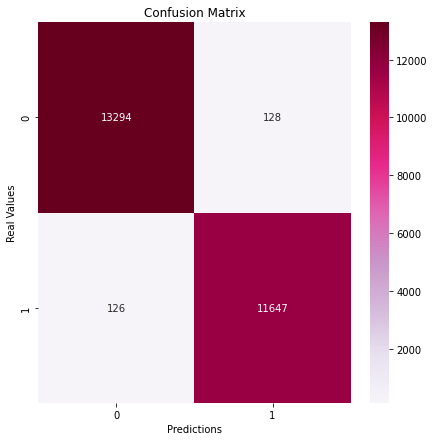

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prédiction sur l'ensemble de test
y_pred = model.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)))
y_pred = (y_pred > 0.5)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calcul de la matrice de confusion
confusion = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion sous forme de heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(confusion, annot=True, cmap='PuRd', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

